In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F

%matplotlib inline

In [2]:
print(torch.backends.mps.is_available())
print(torch.backends.mps.is_built())
torch.device("mps")

True
True


device(type='mps')

In [3]:
class Loader:

    def __init__(self, files):
        self.files = files

    def get_data(self):
        dfs = []
        for file in self.files:
            df = self.load_past_matches(file)
            dfs.append(df)
        
        df_join = self.join_data(dfs[0], dfs[1])

        return df_join

    def load_past_matches(self, file):
        df = pd.read_csv(f'../data/{file}')
        df.drop('Unnamed: 0', axis=1, inplace=True)
        df['date'] = pd.to_datetime(df['date']).dt.date

        return df

    def join_data(self, df1, df2):
        df = pd.merge(df1, df2,  how='inner',
            left_on=['league', 'date','team', 'opponent', 'home'],
            right_on=['league', 'date','team', 'opponent', 'home'])
        df.sort_values(by=['date', 'league', 'team', 'opponent'], inplace=True)
        df.reset_index(inplace=True, drop=True)
              
        return df

In [4]:
FILES = ["elos_matches.csv", "goals_matches.csv"]
loader = Loader(FILES)
data = loader.get_data()
data.shape

(74720, 39)

In [5]:
data.head()

,league,date,team,opponent,result,elo_team,elo_opponent,elo_diff,home,team_goals_scored,...,league_home_goals_conceded,league_away_goals_conceded,league_home_goals_conceded_avg,league_away_goals_conceded_avg,team_attack_strength,team_defense_strength,opponent_attack_strength,opponent_defense_strength,team_lambda,opponent_lambda
0,Serie A,1997-08-31,atalanta,bologna,1.0,1500.0,1500.0,0.0,1,4.0,...,1.444444,1.777778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Serie A,1997-08-31,bari,parma,0.0,1500.0,1500.0,0.0,1,0.0,...,1.444444,1.777778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Serie A,1997-08-31,bologna,atalanta,0.0,1500.0,1500.0,-0.0,0,2.0,...,1.444444,1.777778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Serie A,1997-08-31,brescia,inter_milan,0.0,1500.0,1500.0,-0.0,0,1.0,...,1.444444,1.777778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Serie A,1997-08-31,empoli,roma,0.0,1500.0,1500.0,0.0,1,1.0,...,1.444444,1.777778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
data.tail()

,league,date,team,opponent,result,elo_team,elo_opponent,elo_diff,home,team_goals_scored_avg,...,league_home_goals_conceded,league_away_goals_conceded,league_home_goals_conceded_avg,league_away_goals_conceded_avg,team_attack_strength,team_defense_strength,opponent_attack_strength,opponent_defense_strength,team_lambda,opponent_lambda
74715,"Serie C, Girone B",2023-01-28,san_donato_tavarnelle,reggiana,0.5,1409.437444,1571.499251,-162.061807,1,1.052632,...,0.0,0.0,1.149708,1.109942,1.375132,0.869786,1.144456,0.900948,1.375132,1.144456
74716,"Serie C, Girone B",2023-01-28,siena,olbia,0.5,1433.249597,1363.655427,69.594170,1,0.894737,...,0.0,0.0,1.149708,1.109942,0.758693,0.457782,0.869786,0.995785,0.838556,0.457782
74717,"Serie C, Girone B",2023-01-28,torres,recanatese,0.5,1426.444523,1410.957225,15.487298,1,0.789474,...,0.0,0.0,1.149708,1.109942,0.900948,0.869786,0.961343,0.995785,0.995785,0.961343
74718,"Serie C, Girone B",2023-01-28,virtus_entella,gubbio,0.5,1523.121903,1433.259332,89.862572,1,2.052632,...,0.0,0.0,1.149708,1.109942,1.849315,1.098678,1.190234,0.853530,1.751983,1.503453
74719,"Serie C, Girone B",2023-01-28,vis_pesaro,ancona,0.5,1343.748205,1485.358855,-141.610650,0,0.578947,...,0.0,0.0,1.149708,1.109942,0.595117,1.754478,1.849315,0.869786,0.595117,3.601298


In [6]:
data['result'].value_counts()

1.0    27006
0.0    27006
0.5    20708
Name: result, dtype: int64

In [7]:
data.drop(['team_goals_scored',
           'opponent_goals_scored',
           'team_goals_conceded',
           'opponent_goals_conceded'], axis=1, inplace=True)

In [8]:
print(data.columns)

Index(['league', 'date', 'team', 'opponent', 'result', 'elo_team',
       'elo_opponent', 'elo_diff', 'home', 'team_goals_scored_avg',
       'team_goals_conceded_avg', 'team_goals_scored_avg_home',
       'team_goals_conceded_avg_home', 'team_goals_scored_avg_away',
       'team_goals_conceded_avg_away', 'opponent_goals_scored_avg',
       'opponent_goals_conceded_avg', 'opponent_goals_scored_avg_home',
       'opponent_goals_conceded_avg_home', 'opponent_goals_scored_avg_away',
       'opponent_goals_conceded_avg_away', 'league_home_goals_scored',
       'league_away_goals_scored', 'league_home_goals_scored_avg',
       'league_away_goals_scored_avg', 'league_home_goals_conceded',
       'league_away_goals_conceded', 'league_home_goals_conceded_avg',
       'league_away_goals_conceded_avg', 'team_attack_strength',
       'team_defense_strength', 'opponent_attack_strength',
       'opponent_defense_strength', 'team_lambda', 'opponent_lambda'],
      dtype='object')


In [9]:
def build_dataset(df):
    df_copy = df.copy()
    df_copy.reset_index(inplace=True, drop=True)
    date = df_copy[['date']].iloc[:,0]
    df_copy.drop(['league', 'date', 'team', 'opponent'], axis=1, inplace=True)
    df_copy['date'] = date
    df_copy.sort_values(by=['date'], inplace=True)
    df_copy.drop(['date'], axis=1, inplace=True)
    
    X = df_copy.drop(['result'], axis=1).to_numpy()
    Y = np.array(df_copy['result']) / 0.5
    
    X = torch.tensor(X).float()
    Y = torch.tensor(Y).long()
    
    return X, Y

In [10]:
# n1 = int(0.8 * len(data))
# n2 = int(0.9 * len(data))
# Xtr, Ytr = build_dataset(data[:n1])
# Xdev, Ydev = build_dataset(data[n1:n2])
# Xte, Yte = build_dataset(data[n2:])

In [11]:
def add_past_to_row(df, i):
    df_past = df.copy()
    df_past.index += i
    df_past.rename(columns={c: c+f'_{i}' for c in df_past.columns if c not in ['league',
                                                                               'date',
                                                                               'team',
                                                                               'opponent']}, inplace=True)
    return df_past

In [12]:
def build_matches_dataset(df, past_matches, team):
    dfs_past = []
    df_team = df[df['team']==team]
    for i in range(1, past_matches+1):
        df_past = add_past_to_row(df_team, i)
        dfs_past.append(df_past)

    df_team_joined = df_team.copy()
    for df_past in dfs_past:
        df_team_joined = pd.concat([df_team_joined, df_past],
                                    axis=1,
                                    )
    df_team_joined = df_team_joined[past_matches:-past_matches]

    return df_team_joined

In [13]:
def build_teams_dataset(df, past_matches):
    dfs = []
    for team in df['team'].unique():
        df_team_joined = build_matches_dataset(df, past_matches, team)
        dfs.append(df_team_joined)
    dfs = pd.concat(dfs)
    dfs.insert(5, 'result_0', 0)
    dfs = add_opponent_past_matches(dfs)
    dfs = ordering_columns(dfs, past_matches)

    return dfs

In [14]:
def add_opponent_past_matches(df):
    df = df.loc[:,~df.columns.duplicated()].copy()
    df_copy = df.copy()
    keep_same = {'league', 'date', 'team', 'opponent', 'result'}
    df_copy.columns = ['{}{}'.format(c, '' if c in keep_same else '_y') for c in df_copy.columns]
    df_copy['result'] = 1 - df_copy['result']
    df_copy.rename(columns={'team': 'opponent', 'opponent': 'team'}, inplace=True)
    df_combined = pd.merge(df, df_copy, how='left',
                          left_on=['league', 'date', 'team', 'opponent', 'result'],
                          right_on=['league', 'date', 'team', 'opponent', 'result'])
    return df_combined

In [15]:
def ordering_columns(df, past_matches):
    index_columns = ['league', 'date', 'team', 'opponent', 'result']
    template_columns = ['result', 'elo_team', 'elo_opponent', 'elo_diff', 'home', 'team_goals_scored_avg',
                       'team_goals_conceded_avg', 'team_goals_scored_avg_home',
                       'team_goals_conceded_avg_home', 'team_goals_scored_avg_away',
                       'team_goals_conceded_avg_away', 'opponent_goals_scored_avg',
                       'opponent_goals_conceded_avg', 'opponent_goals_scored_avg_home',
                       'opponent_goals_conceded_avg_home', 'opponent_goals_scored_avg_away',
                       'opponent_goals_conceded_avg_away', 'league_home_goals_scored',
                       'league_away_goals_scored', 'league_home_goals_scored_avg',
                       'league_away_goals_scored_avg', 'league_home_goals_conceded',
                       'league_away_goals_conceded', 'league_home_goals_conceded_avg',
                       'league_away_goals_conceded_avg', 'team_attack_strength',
                       'team_defense_strength', 'opponent_attack_strength',
                       'opponent_defense_strength', 'team_lambda', 'opponent_lambda']
    template_columns_y = [s + f'_y' for s in template_columns]
    columns = [[index_columns + ['result_0'] + template_columns[1:] + ['result_0_y'] + template_columns_y[1:]]]
    for i in range(1, past_matches+1):
        team_cols = [s + f'_{i}' for s in template_columns]
        opp_cols = [s + f'_{i}_y' for s in template_columns]
        columns.append([team_cols, opp_cols])

    columns = [subitem for sublist in columns for item in sublist for subitem in item]
    df = df[columns]
    df.dropna(inplace=True)
    df.reset_index(inplace=True, drop=True)
    return df

In [16]:
def build_wavenet_dataset(df, past_matches=7):
    df_copy = df.copy()
    df_copy.sort_values(by=['team', 'date'], inplace=True)
    df_copy.reset_index(inplace=True, drop=True)
    dfs = build_teams_dataset(df_copy, past_matches)
    X, Y = build_dataset(dfs)
    
    return X, Y, dfs

#     return dfs

In [17]:
# def build_wavenet_dataset(df, past_matches=8):
#     df_copy = df.copy()
#     df_copy.sort_values(by=['team', 'date'], inplace=True)
#     df_copy.reset_index(inplace=True, drop=True)
    
#     dfs = []
#     for team in df_copy['team'].unique():
#         dfs_past = []
#         df_team = df_copy[df_copy['team']==team]

#         for i in range(1, past_matches+1):
#             df_past = df_team.copy()
#             df_past.index += i
#             df_past.rename(columns={c: c+f'_{i}' for c in df_past.columns if c not in ['league',
#                                                                                        'date',
#                                                                                        'team']}, inplace=True)
#             dfs_past.append(df_past)
            
#         df_team_joined = df_team.copy()
#         for df_past in dfs_past:
#             df_team_joined = pd.concat([df_team_joined, df_past],
#                                         axis=1,
#                                         )
            
#         dfs.append(df_team_joined)
#         break
        
#     return dfs

In [18]:
Xall, Yall, dfs = build_wavenet_dataset(data, 7)

/var/folders/bl/xbg_536n2_n123s38z4hxbx00000gn/T/ipykernel_52410/1032692087.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


In [21]:
for column in dfs.columns:
    print(column)

league
date
team
opponent
result
result_0
elo_team
elo_opponent
elo_diff
home
team_goals_scored_avg
team_goals_conceded_avg
team_goals_scored_avg_home
team_goals_conceded_avg_home
team_goals_scored_avg_away
team_goals_conceded_avg_away
opponent_goals_scored_avg
opponent_goals_conceded_avg
opponent_goals_scored_avg_home
opponent_goals_conceded_avg_home
opponent_goals_scored_avg_away
opponent_goals_conceded_avg_away
league_home_goals_scored
league_away_goals_scored
league_home_goals_scored_avg
league_away_goals_scored_avg
league_home_goals_conceded
league_away_goals_conceded
league_home_goals_conceded_avg
league_away_goals_conceded_avg
team_attack_strength
team_defense_strength
opponent_attack_strength
opponent_defense_strength
team_lambda
opponent_lambda
result_0_y
elo_team_y
elo_opponent_y
elo_diff_y
home_y
team_goals_scored_avg_y
team_goals_conceded_avg_y
team_goals_scored_avg_home_y
team_goals_conceded_avg_home_y
team_goals_scored_avg_away_y
team_goals_conceded_avg_away_y
opponent_go

In [22]:
dfs.shape

(69316, 501)

In [23]:
Xall.shape

torch.Size([69316, 496])

In [22]:
# for column in dfs.columns:
#     print(column)

In [23]:
# dfs[dfs.isna().any(axis=1)]

In [24]:
n1 = int(0.8 * Xall.shape[0])
n2 = int(0.9 * Xall.shape[0])

Xtr, Ytr = Xall[:n1], Yall[:n1]
Xdev, Ydev = Xall[n1:n2], Yall[n1:n2]
Xte, Yte = Xall[n2:], Yall[n2:]

In [25]:
Xtr.shape

torch.Size([52025, 992])

In [26]:
inputs_per_match = data.drop(['league', 'date', 'team', 'opponent'], axis=1).shape[1]*2

In [27]:
inputs_per_match

62

In [28]:
496/62

8.0

In [77]:
torch.manual_seed(1337)
conv1 = 16
conv2 = 32
conv3 = 64
conv4 = 128
n_hidden = 25

model = torch.nn.Sequential(
    torch.nn.Conv1d(1, conv1, kernel_size=inputs_per_match, stride=inputs_per_match), torch.nn.BatchNorm1d(conv1), torch.nn.Tanh(),
    torch.nn.Conv1d(conv1, conv2, kernel_size=2, stride=2), torch.nn.BatchNorm1d(conv2), torch.nn.Tanh(),
    torch.nn.Conv1d(conv2, conv3, kernel_size=2, stride=2), torch.nn.BatchNorm1d(conv3), torch.nn.Tanh(),
#     torch.nn.Conv1d(conv3, conv3, kernel_size=2, stride=2), torch.nn.BatchNorm1d(conv3), torch.nn.Tanh(),
    torch.nn.Flatten(),
    torch.nn.Linear(conv4*2, 3)
)

# model.to('mps')

with torch.no_grad():
    model[-1].weight *= 0.1

parameters = [p for layer in model for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.retain_grad()
    p.requires_grad = True

7219


In [78]:
max_steps = 300000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    ix = torch.randint(0, Xtr.shape[0], (32, ))
    X, Y = Xtr[ix], Ytr[ix]
    
    X = X[:, None, :]
    logits = model(X)
    loss = F.cross_entropy(logits, Y)
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update weights
    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/ 300000: 1.1092
  10000/ 300000: 1.0895
  20000/ 300000: 1.0399
  30000/ 300000: 0.9377
  40000/ 300000: 0.9345
  50000/ 300000: 0.9545
  60000/ 300000: 1.0106
  70000/ 300000: 1.0385
  80000/ 300000: 0.8809
  90000/ 300000: 1.0511
 100000/ 300000: 0.9272
 110000/ 300000: 0.9996
 120000/ 300000: 0.9622
 130000/ 300000: 1.0018
 140000/ 300000: 0.8563
 150000/ 300000: 0.9752
 160000/ 300000: 0.9527
 170000/ 300000: 0.7745
 180000/ 300000: 0.9336
 190000/ 300000: 1.0692
 200000/ 300000: 1.0657
 210000/ 300000: 0.9747
 220000/ 300000: 0.8350
 230000/ 300000: 0.7301
 240000/ 300000: 0.8810
 250000/ 300000: 0.8734
 260000/ 300000: 0.9530
 270000/ 300000: 0.9626
 280000/ 300000: 1.0042
 290000/ 300000: 0.7326


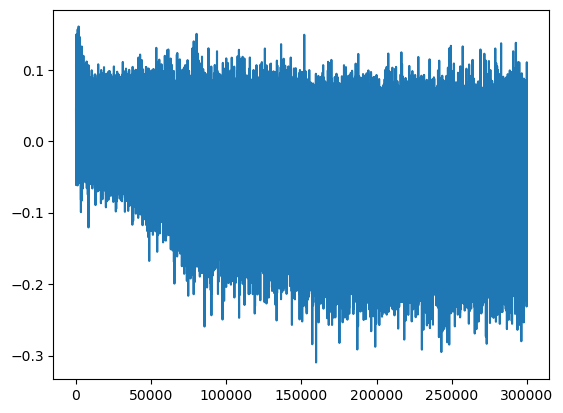

In [79]:
plt.plot(lossi)

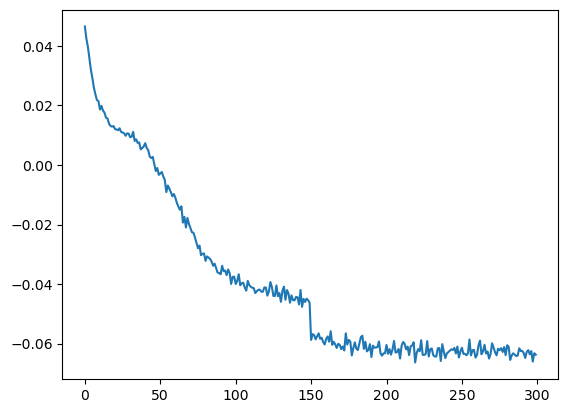

In [80]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [81]:
# PATH = "../src/model/trained_models/wavenet_9.pt"
# model.eval()
# torch.save(model.state_dict(), PATH)
# torch.save(model, PATH)

In [82]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': [Xtr, Ytr],
        'val'  : [Xdev, Ydev],
        'test' : [Xte, Yte]
    }[split]
    
    x = x[:, None, :]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

In [83]:
model.train()
split_loss('train')
split_loss('val')

train 0.8645122051239014
val 0.9102889895439148


In [84]:
@torch.no_grad()
def accuracy(split):
    x, y = {
        'train': [Xtr, Ytr],
        'val'  : [Xdev, Ydev],
        'test' : [Xte, Yte]
    }[split]
    
    x = x[:, None, :]
    logits = model(x)
    preds = []
    preds = torch.argmax(logits, dim=1)

    i = 0
    for pred, true in zip(preds, y):
        if pred == true:
            i += 1
    
    print(f"----{split}----")
    print(f"Correctly predicted {i} out of {y.shape[0]} in {split}.")
    print(f"{i / y.shape[0]:.4f}")
    print(f"Guessing would give an accuracy of {1 / len(torch.unique(y))}")

In [85]:
accuracy('train')
accuracy('val')

----train----
Correctly predicted 30739 out of 52025 in train.
0.5909
Guessing would give an accuracy of 0.3333333333333333
----val----
Correctly predicted 3622 out of 6503 in val.
0.5570
Guessing would give an accuracy of 0.3333333333333333


## Tracker
#### 22, 915 parameters, wavenet 3 conv layers, doubling 32 n_hidden, 8 past_matches, 100,000 steps; wavenet
- Loss:     Trained model: train:0.7977, val:0.8445
- Accuracy: Trained model: train:0.6263, val:0.5931
#### 22, 915 parameters, wavenet 3 conv layers, doubling 32 n_hidden, 8 past_matches, 200,000 steps; wavenet_2
- Loss:     Trained model: train:0.7473, val:0.8068
- Accuracy: Trained model: train:0.6503, val:0.6179
#### 22, 915 parameters, wavenet 3 conv layers, doubling 32 n_hidden, 8 past_matches, 300,000 steps; wavenet_3
- Loss:     Trained model: train:0.7399, val:0.8058
- Accuracy: Trained model: train:0.6545, val:0.6209
#### 22, 915 parameters, wavenet 3 conv layers, doubling 32 n_hidden, 11 past_matches, 100,000 steps;
- Loss:     Trained model: train:0.7949, val:0.8588
- Accuracy: Trained model: train:0.6227, val:0.5884
#### 22, 915 parameters, wavenet 3 conv layers, doubling 32 n_hidden, 11 past_matches, 200,000 steps;
- Loss:     Trained model: train:0.7425, val:0.8150
- Accuracy: Trained model: train:0.6524, val:0.6116
#### 89,219 parameters, wavenet 4 conv layers, doubling 32 n_hidden, 11 past_matches, 100,000 steps; wavenet_5
- Loss:     Trained model: train:0.7617, val:0.8534
- Accuracy: Trained model: train:0.6387, val:0.5863

### Removing Duplicate Goals
#### 22, 915 parameters, wavenet 3 conv layers, doubling 32 n_hidden, 8 past_matches, 300,000 steps; wavenet_4
- Loss:     Trained model: train:0.8644, val:0.9042
- Accuracy: Trained model: train:0.5909, val:0.5610
#### 22, 915 parameters, wavenet 3 conv layers, doubling 32 n_hidden, 11 past_matches, 200,000 steps;
- Loss:     Trained model: train:0.8727, val:0.9099
- Accuracy: Trained model: train:0.5861, val:0.5593
#### 22, 915 parameters, wavenet 3 conv layers, doubling 32 n_hidden, 11 past_matches, 300,000 steps;
- Loss:     Trained model: train:0.8646, val:0.9030
- Accuracy: Trained model: train:0.5903, val:0.5573
#### 89,219 parameters, wavenet 4 conv layers, doubling 32 n_hidden, 8 past_matches, 200,000 steps; wavenet_5
- Loss:     Trained model: train:0.8328, val:0.9306
- Accuracy: Trained model: train:0.6140, val:0.5492
#### OVERFIT 89,987 parameters, wavenet 4 conv layers, doubling 32 n_hidden, 17 past_matches, 300,000 steps; wavenet_6
- Loss:     Trained model: train:0.7332, val:1.0322
- Accuracy: Trained model: train:0.6768, val:0.5284

### Updated Data - Both Team's History
#### 7,219 parameters, wavenet 3 conv layers, doubling 16 n_hidden, 16 past_matches, 100,000 steps;
- Loss:     Trained model: train:0.9112, val:0.9476
- Accuracy: Trained model: train:0.5632, val:0.5384
#### 7,219 parameters, wavenet 3 conv layers, doubling 16 n_hidden, 16 past_matches, 300,000 steps; wavenet_8
- Loss:     Trained model: train:0.8645, val:0.9102
- Accuracy: Trained model: train:0.5909, val:0.5570
#### 23,907 parameters, wavenet 3 conv layers, doubling 32 n_hidden, 8 past_matches, 100,000 steps;
- Loss:     Trained model: train:0.9218, val:0.9537
- Accuracy: Trained model: train:0.5611, val:0.5329
#### 23,907 parameters, wavenet 3 conv layers, doubling 32 n_hidden, 8 past_matches, 300,000 steps; wavenet_7
- Loss:     Trained model: train:0.8608, val:0.9185
- Accuracy: Trained model: train:0.5956, val:0.5525
#### 90,211 parameters, wavenet 4 conv layers, doubling 32 n_hidden, 8 past_matches, 100,000 steps;
- Loss:     Trained model: train:0.9247, val:0.9869
- Accuracy: Trained model: train:0.5572, val:0.5080
#### 90,211 parameters, wavenet 4 conv layers, doubling 32 n_hidden, 8 past_matches, 200,000 steps;
- Loss:     Trained model: train:0.8576, val:1.0010
- Accuracy: Trained model: train:0.6052, val:0.5178
#### 56,675 parameters, wavenet 4 conv layers, doubling 32 n_hidden, 8 past_matches, 100,000 steps;
- Loss:     Trained model: train:0.9252, val:1.0000
- Accuracy: Trained model: train:0.5547, val:0.5047

In [44]:
# dfs.sort_values(by='date').head()
dfs_test = dfs.loc[:,~dfs.columns.duplicated()]
dfs_test.sort_values(by='date').head(10)

,league,date,team,opponent,result,result_0,elo_team,elo_opponent,elo_diff,home,...,league_home_goals_conceded_16,league_away_goals_conceded_16,league_home_goals_conceded_avg_16,league_away_goals_conceded_avg_16,team_attack_strength_16,team_defense_strength_16,opponent_attack_strength_16,opponent_defense_strength_16,team_lambda_16,opponent_lambda_16
30741,Serie A,1998-01-25,inter_milan,empoli,0.5,0,1605.394479,1438.779887,166.614593,0.0,...,1.444444,1.777778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11373,Serie A,1998-01-25,brescia,parma,1.0,0,1445.044027,1560.490559,-115.446532,1.0,...,1.444444,1.777778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43945,Serie A,1998-01-25,napoli,bari,0.0,0,1372.108075,1485.486412,-113.378337,0.0,...,1.444444,1.777778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10108,Serie A,1998-01-25,bologna,lazio,0.0,0,1469.661664,1555.798423,-86.136759,0.0,...,1.444444,1.777778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48053,Serie A,1998-01-25,parma,brescia,0.0,0,1560.490559,1445.044027,115.446532,0.0,...,1.444444,1.777778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22125,Serie A,1998-01-25,empoli,inter_milan,0.5,0,1438.779887,1605.394479,-166.614593,1.0,...,1.444444,1.777778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24507,Serie A,1998-01-25,fiorentina,milan,1.0,0,1519.402007,1520.912491,-1.510484,0.0,...,1.444444,1.777778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41411,Serie A,1998-01-25,milan,fiorentina,0.0,0,1520.912491,1519.402007,1.510484,1.0,...,1.444444,1.777778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8384,Serie A,1998-01-25,bari,napoli,1.0,0,1485.486412,1372.108075,113.378337,1.0,...,1.444444,1.777778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6068,Serie A,1998-01-25,atalanta,juventus,0.0,0,1445.724894,1603.133120,-157.408226,0.0,...,1.444444,1.777778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
